## Proyecto de Geoinformática: Multiprocesos

#### Autores: 
* González, Luis
* Morgado, Julio 

En esta nueva sección cambiamos el tema de interés puesto que no hay tantas observaciones en el ejemplo de ciclovías. Ahora, utilizaremos datos de lesiones de la Secretaría de Salud del 2020. Nos interesa saber cuántas lesiones han utilizado servicios de atención prehospitalaria en las diferentes localidades del país, ademas, conocer cual es la principal afección de dichas lesiones. El objetivo final es generar una par de gráficas que correspondan las diferentes entidades y nos indique el número de lesiones con servicio de urgencias en las localidades y cuál es la afección principal más común en las mismas. A continuación se presentan los paquetes requeridos. 

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from joblib import Parallel, delayed
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')

**Funciones utilizadas**

La función principal es la de *graph_map_bar* que utiliza el resultado de la función paralelizada de *map_bar* para poder visualizar los resultados en las entidades. Adicionalmente, se crearon otras funciones como *cie* para facilitar la lectura del código CIE en sus diferentes niveles o *pal_lineas* para generar espacios en la descripción del CIE al momento de graficar. 

In [2]:
# Función para pegar el código CIE dependiendo del nivel de detalle
def cie(df, var_cie, n_cie=None):
    if n_cie!=None:
        df[var_cie] = df[var_cie].apply(lambda x: x[:n_cie])
    cie = pd.read_csv('data/CAT_CIE-10_2020.csv', 
                      index_col=None, encoding='latin')[['Clave','Nombre']].rename(columns={'Clave':var_cie})
    return pd.merge(df, cie, on=var_cie, how='left')

# Cambiar las etiquetas de variable prehospitalaria
def prehosp(series):
    if series==1:
        return 'Si'
    elif series==2:
        return 'No'
    else:
        np.nan

# Poner enter a lineas de texto en CIE 
def pal_lineas(txt):
    t = []
    if len(txt.split(' '))>4:
        c = 4
        while c<len(txt.split(' ')):
            t.append(' '.join(txt.split(' ')[c-4:c]) + '\n')
            c+=4
        t.append(' '.join(txt.split(' ')[c-4:]))
        return ' '.join(t)
    else:
        return txt

# Graficar los resultados de función
def graph_map_bar(info):
    for i in range(len(info[0])):
        df = gpd.GeoDataFrame(pd.DataFrame(info[i][0]), geometry=0, crs=3857)
        df.columns = ['geometry','values']
        df['values'] = df['values'].astype(float)
        dff = pd.DataFrame(info[1][i])
        dff.columns = ['tipo','value']
        dff.iloc[:,0] = dff.iloc[:,0].apply(lambda x: pal_lineas(x))
        
        fig, ax = plt.subplots(1,2,figsize=(20,8), gridspec_kw={'width_ratios': [1, 2]})
        sns.barplot(data=dff, x='value', y='tipo', ax=ax[0], 
                    palette=reversed(sns.color_palette('Blues', dff.shape[0])))
        df.plot('values', cmap='Blues', scheme='naturalbreaks', ax=ax[1])
        ax[1].set_axis_off()
        ax[0].set_title('Principales afecciones de lesiones\nque requirieron atención prehospitalaria')
        ax[0].set_ylabel('')
        ax[0].set_xlabel('')
        ax[1].set_title('Concentración de lesiones que \nrequirieron atención prehospitalaria')
        plt.tight_layout()
        plt.show()

**Función a paralelizar**

A continuación se presenta la función a paralelizar, lo importante es generar conteos de bases de datos mayores al medio millon de observaciones de una forma iterativa dependiendo del número de entidades que se desea analizar. Igualmente, se requiere de hacer conteos distintos para saber los tipos de servicios prehospitalarios y las afecciones de los pacientes. Por lo tanto, en caso de aumentar el número de años, es una función muy útil para poder analizar cantidades superiores a al millón o incluso 5 millones de observaciones que cuenta la SSA en el último lustro. 

In [3]:
def map_bar(ent):
    # Carga de polígonos a nivel localidad
    shp = gpd.read_file('data/Localidades_urbanas2013.gpkg')[['ClAVE','geometry']]
    shp.columns = ['cvegeo','geometry']
    shp.set_index('cvegeo', inplace=True)
    resultados = [[],[]]
    les = pd.read_csv('data/D_Evento.txt', index_col='ID',
                      dtype={'CodEstado':str, 'CodMunicipio':str, 'CodLocalidad':str})
    les = les[les.CodLocalidad!='9999']
    les['cvegeo'] = les['CodEstado'] + les['CodMunicipio'] + les['CodLocalidad']
    les['CodPrehospitalaria'] = les.CodPrehospitalaria.apply(lambda x: prehosp(x))
    
    # Generar lesiones por localidad que usaron servicios prehosp
    df = les[les.CodEstado==ent].groupby(['cvegeo','CodPrehospitalaria']).size().unstack()
    df.fillna(0, inplace=True)
    df['les_per100'] = round(df.iloc[:,1]/((df.iloc[:,1]+df.iloc[:,0])/100),0)
    df = pd.concat([df, shp], axis=1, join='inner')
    resultados[0].append(np.array(df[['geometry','les_per100']]))
    del df
    
    # Generar principales afecciones por localidad
    df= les[(les.CodEstado==ent)&(les.CodPrehospitalaria=='Si')].groupby(['cvegeo','AFECPRIN'], as_index=False).size()
    df = cie(df, 'AFECPRIN', 3)
    df = df.groupby(['AFECPRIN','Nombre'], as_index=False)['size'].sum()
    df.sort_values('size',ascending=False, inplace=True)
    resultados[1].append(np.array(df.head(10)[['Nombre','size']]))
    del df
    return resultados

Aqui podemos ver como se puede visualizar el resultado de la función *map_bar* en la Ciudad de México. Por lo tanto, ahora sería más sencillo ir generando gráficos por entidad. 

In [4]:
var_edos = [str(x).zfill(2) for x in list(range(1,33))]
 
# Ejemplo con la CDMX
r = map_bar(var_edos[8])

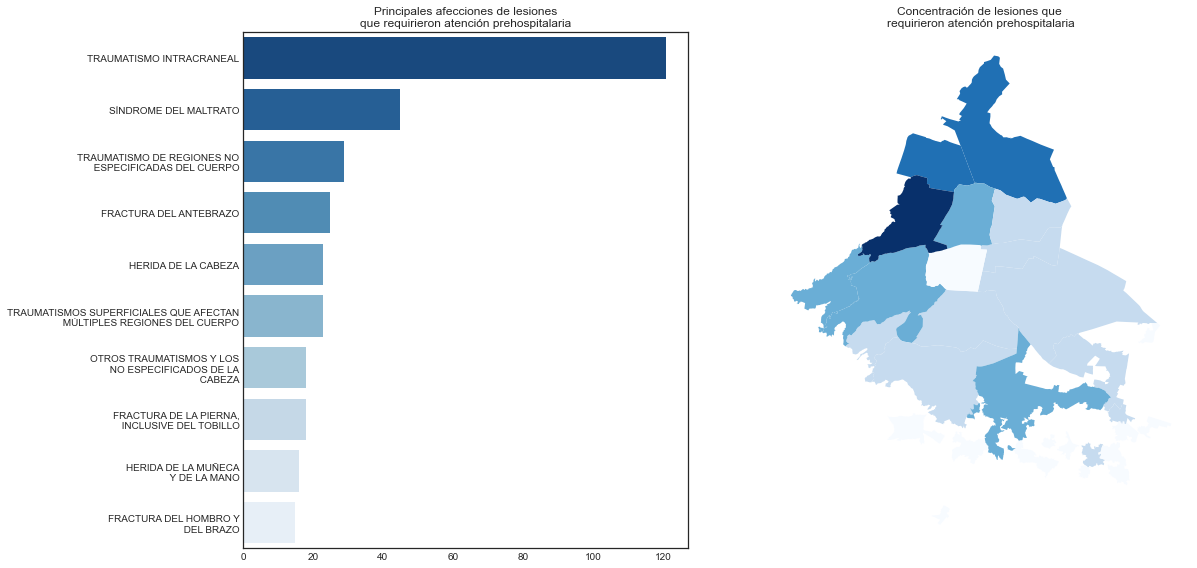

In [5]:
graph_map_bar(r)

**Pruebas de tiempo**

In [6]:
%%time
r = []
for i in var_edos:
    r.append(map_bar(i))

Wall time: 1min 39s


In [7]:
%%time
r = Parallel(n_jobs=1,backend='multiprocessing')(delayed(map_bar)(i) for i in var_edos)

Wall time: 1min 47s


**Conclusiones**